In [2]:
# Load datasets
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor

rents = pd.read_csv("../data/processed_rents.csv").head(10000) 


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(data, target_column):
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

    correlated_features = corr_matrix[target_column][abs(corr_matrix[target_column]) > 0.7]
    plt.figure(figsize=(8, 6))
    correlated_features.drop(target_column).plot(kind='bar', color='skyblue')
    plt.title(f'Features Correlated with {target_column}')
    plt.ylabel('Correlation Coefficient')
    plt.show()

def plot_univariate_selection(selector, X):
    scores = selector.scores_
    features = X.columns
    indices = np.argsort(scores)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), scores[indices], align="center", color="lightgreen")
    plt.xticks(range(len(features)), features[indices], rotation=90)
    plt.title('Univariate Feature Scores')
    plt.ylabel('Score')
    plt.show()



def plot_feature_importances(model, X):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), importances[indices], align="center", color="salmon")
    plt.xticks(range(len(features)), features[indices], rotation=90)
    plt.title('Feature Importances from RandomForest')
    plt.ylabel('Importance')
    plt.show()


def plot_rfe_results(rfe_selector, X):
    ranks = rfe_selector.ranking_
    features = X.columns

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), ranks, align="center", color="lightblue")
    plt.xticks(range(len(features)), features, rotation=90)
    plt.title('Feature Rankings from RFE')
    plt.ylabel('Rank')
    plt.show()




In [4]:
data=rents
target_column="annual_amount"

X = data.drop(target_column, axis=1)
y = data[target_column]
 

In [5]:
# Correlation Analysis
corr_matrix = data.corr()
correlated_features = corr_matrix[target_column][abs(corr_matrix[target_column]) > 0.7].index.tolist()


In [6]:
# Univariate feature selection
univariate_selector = SelectKBest(score_func=mutual_info_regression, k=10)
univariate_selector.fit(X, y)

SelectKBest(score_func=<function mutual_info_regression at 0x7697cee69fc0>)

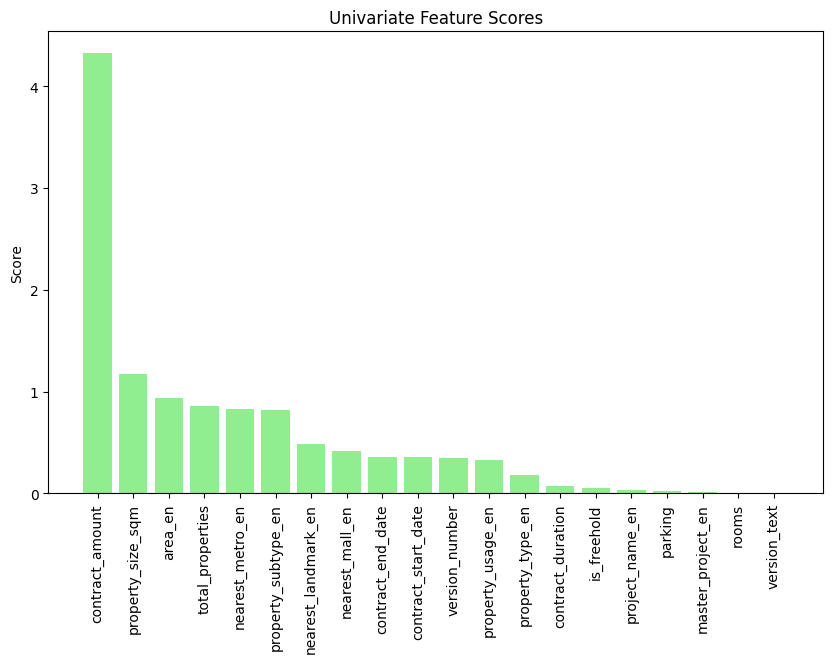

In [7]:
plot_univariate_selection(univariate_selector, X)

In [8]:
# Feature importance with tree-based models
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = model.feature_importances_

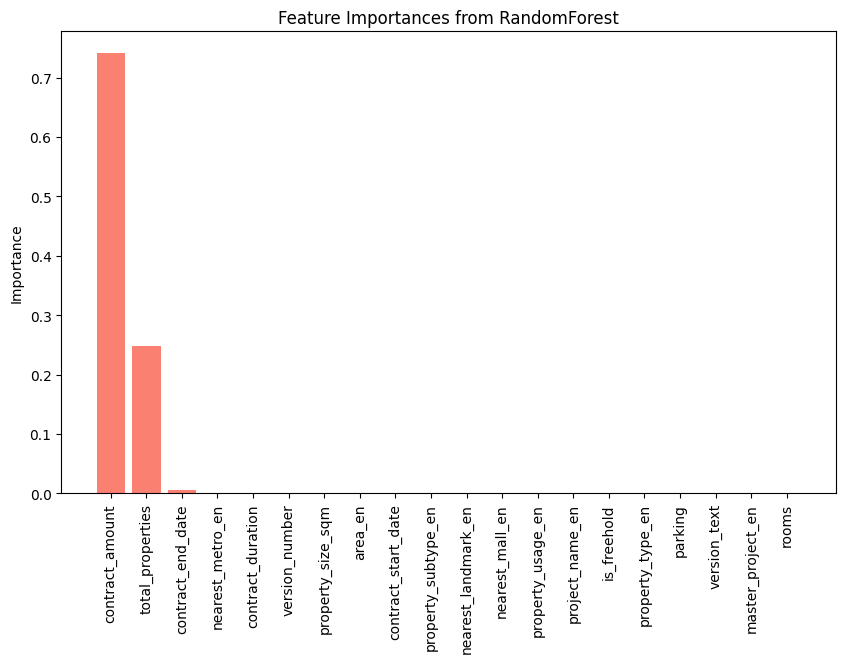

In [9]:
plot_feature_importances(model, X)

In [10]:
# # Recursive Feature Elimination (RFE)
# rfe_selector = RFE(estimator=model, n_features_to_select=10)
# rfe_selector.fit(X, y)

In [11]:
# plot_rfe_results(rfe_selector, X)

In [12]:
# Combine selected features
# selected_features = set(correlated_features + list(X.columns[univariate_selector.get_support()]) + list(X.columns[rfe_selector.get_support()]))


In [13]:


def feature_selection(data, target_column):
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Correlation Analysis
    corr_matrix = data.corr()
    correlated_features = corr_matrix[target_column][abs(corr_matrix[target_column]) > 0.7].index.tolist()

    # Univariate feature selection
    univariate_selector = SelectKBest(score_func=mutual_info_regression, k=10)
    univariate_selector.fit(X, y)

    # Feature importance with tree-based models
    model = RandomForestRegressor()
    model.fit(X, y)
 
    # Recursive Feature Elimination (RFE)
    rfe_selector = RFE(estimator=model, n_features_to_select=10)
    rfe_selector.fit(X, y)

    # Combine selected features
    selected_features = set(correlated_features + list(X.columns[univariate_selector.get_support()]) + list(X.columns[rfe_selector.get_support()]))
    return list(selected_features)


In [14]:
rent_features = feature_selection(rents, "contract_amount")

In [15]:
rent_features

['nearest_metro_en',
 'contract_amount',
 'nearest_landmark_en',
 'version_number',
 'contract_end_date',
 'area_en',
 'annual_amount',
 'nearest_mall_en',
 'property_usage_en',
 'project_name_en',
 'property_size_sqm',
 'contract_start_date',
 'contract_duration',
 'property_subtype_en',
 'total_properties']

In [16]:
rent_features=['contract_start_date',
 'version_number',
 'contract_end_date',
 'area_en',
 'nearest_metro_en',
 'property_size_sqm']

In [17]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV

def train_base_models(X, y):
    models = {
        "XGBoost": xgb.XGBRegressor(),
        "Random Forest": RandomForestRegressor(),
        "SVR": SVR()
    }
    
    tuned_models = {}
    for name, model in models.items():
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces={
                'XGBoost': {'max_depth': (3, 10), 'n_estimators': (50, 300)},
                'Random Forest': {'max_depth': (3, 10), 'n_estimators': (50, 300)},
                'SVR': {'C': (0.1, 10.0), 'gamma': (0.01, 1.0)}
            }[name],
            n_iter=20,
            cv=3
        )
        bayes_search.fit(X, y)
        tuned_models[name] = bayes_search.best_estimator_

    return tuned_models


In [18]:
base_models = train_base_models(data[rent_features], data["contract_amount"])

/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.int64(50)] before, using random point [np.int64(5), np.int64(91)]
  warnings.warn(
/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.int64(50)] before, using random point [np.int64(8), np.int64(145)]
  warnings.warn(
/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: Use

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

def train_meta_learner(base_model_predictions, y):
    X_train, X_test, y_train, y_test = train_test_split(base_model_predictions, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(64, activation="relu", input_dim=X_train.shape[1]),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")
    ])
    
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    
    return model


2024-11-17 15:57:08.090338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 15:57:08.091401: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:57:08.094352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:57:08.100708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731844628.109926  143531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731844628.11

In [20]:
meta_learner = train_meta_learner(np.array([model.predict(data[rent_features]) for model in base_models.values()]).T, data["contract_amount"])

Epoch 1/50


/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-17 15:57:14.898954: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5493 - mae: 0.4856 - val_loss: 0.0289 - val_mae: 0.1185
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0522 - mae: 0.1257 - val_loss: 0.0142 - val_mae: 0.0746
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0420 - mae: 0.1193 - val_loss: 0.0068 - val_mae: 0.0490
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450 - mae: 0.1070 - val_loss: 0.0094 - val_mae: 0.0742
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517 - mae: 0.1128 - val_loss: 0.0091 - val_mae: 0.0619
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351 - mae: 0.1015 - val_loss: 0.0065 - val_mae: 0.0535
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0583 - mae: 0.1082 - val_loss: 0.0063 - val_mae: 0.0534
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312 - mae: 0.1012 - val_loss: 0.0062 - val_mae: 0.0450
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0403 - mae: 0.0947 - va

In [21]:
base_models

{'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'Random Forest': RandomForestRegressor(max_depth=6, n_estimators=300),
 'SVR': SVR(C=10.0, gamma=1.0)}

In [33]:
meta_learner.input_shape

(None, 3)

In [23]:
import numpy as np

# Prepare base model predictions for the meta-learner
base_model_predictions = np.array([
    model.predict(data[rent_features]) for model in base_models.values()
]).T
print("Base predictions shape:", base_model_predictions.shape)  # Debugging line
# Make predictions using the meta-learner
meta_predictions = meta_learner.predict(base_model_predictions)


Base predictions shape: (1000, 3)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [24]:
import joblib

# Save meta-learner and base models
joblib.dump(meta_learner, "meta_learner.pkl")
for name, model in base_models.items():
    joblib.dump(model, f"{name}.pkl")


In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {"RMSE": rmse, "R2": r2, "MAE": mae}


In [26]:
# Evaluate the model
print("Rent Model Evaluation:", evaluate_model(data["contract_amount"], meta_predictions))

Rent Model Evaluation: {'RMSE': np.float64(0.1142335437763974), 'R2': 0.9869506974762859, 'MAE': np.float64(0.06427614799472417)}


/home/noaman/Desktop/smartbricks/sbenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
print(meta_learner.input_shape)

(None, 3)


In [28]:
print(base_model_predictions.shape)

(1000, 3)


In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from joblib import load

# Define preprocessing functions
def handle_missing_data(df):
    # Fill categorical missing values with "Unknown"
    categorical_cols = df.select_dtypes(include=["object"]).columns
    df[categorical_cols] = df[categorical_cols].fillna("Unknown")

    # Fill numerical missing values with median
    numerical_cols = df.select_dtypes(include=["number"]).columns
    imputer = SimpleImputer(strategy="median")
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

    return df

def feature_engineering(df_rents):
    # Add contract duration in days
    df_rents["contract_duration"] = (
        pd.to_datetime(df_rents["contract_end_date"]) - pd.to_datetime(df_rents["contract_start_date"])
    ).dt.days
    return df_rents

def encode_categorical_with_frequency(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        freq_map = df[col].value_counts().to_dict()
        df[col] = df[col].map(freq_map)
    return df

def scale_numerical(df):
    numerical_cols = df.select_dtypes(include=["number"]).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# Load pre-trained models
meta_learner = load("meta_learner.pkl")
base_models = {
    "xgboost": load("XGBoost.pkl"),
    "random_forest": load("Random Forest.pkl"),
    "svr": load("SVR.pkl"),
}

# Full preprocessing pipeline
def preprocess_input_data(new_data):
    # Handle missing data
    new_data = handle_missing_data(new_data)

    # Perform feature engineering
    # new_data = feature_engineering(new_data)

    # Encode categorical variables
    new_data = encode_categorical_with_frequency(new_data)

    # Scale numerical features
    new_data = scale_numerical(new_data)

    return new_data

# Generate base predictions
def generate_base_predictions(new_data, features):
    base_predictions = np.array([
        model.predict(new_data[features]) for model in base_models.values()
    ]).T
 
    print("Base predictions shape:", base_predictions.shape)  # Debugging line
    return base_predictions

# Predict function
def predict_rent(new_data, features):
    # Preprocess the input data
    processed_data = preprocess_input_data(new_data)

   
    # Generate base model predictions
    base_predictions = generate_base_predictions(processed_data, features)

    # Make final predictions using the meta-learner
    final_predictions = meta_learner.predict(base_predictions)
    return final_predictions




In [30]:
meta_learner.output_shape

(None, 1)

In [34]:
rent_features

['contract_start_date',
 'version_number',
 'contract_end_date',
 'area_en',
 'nearest_metro_en',
 'property_size_sqm']

In [35]:


# Convert to DataFrame
new_data_df = rents = pd.read_csv("/home/noaman/Desktop/smart bricks/SB-Case Study Materials/data/snp_dld_2024_rents.csv") 
new_data_df=new_data_df[rent_features]
new_data_df


/tmp/ipykernel_143531/3850914726.py:2: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data_df = rents = pd.read_csv("/home/noaman/Desktop/smart bricks/SB-Case Study Materials/data/snp_dld_2024_rents.csv")


,contract_start_date,version_number,contract_end_date,area_en,nearest_metro_en,property_size_sqm
0,2024-01-01,12,2024-12-31,Al Nahda Second,Al Nahda Metro Station,120.76
1,2024-03-18,12,2025-03-17,Mirdif,Rashidiya Metro Station,159.03
2,2024-01-01,12,2024-12-31,Al Muteena,Salah Al Din Metro Station,60.94
3,2024-01-01,12,2024-12-31,Al Barsha First,Sharaf Dg Metro Station,108.88
4,2024-01-01,12,2024-12-31,Al Qusais First,Airport Free Zone,57.60
...,...,...,...,...,...,...
747403,2024-02-16,11,2025-02-15,Al Qusais First,Airport Free Zone,96.45
747404,2024-10-18,13,2025-10-17,Al Mamzer,STADIUM Metro Station,148.00
747405,2024-09-01,13,2025-08-31,Al Dhagaya,Palm Deira Metro Stations,23.57
747406,2024-08-07,13,2025-08-06,Al Barsha First,Sharaf Dg Metro Station,139.17


In [36]:
new_data_df.columns

Index(['contract_start_date', 'version_number', 'contract_end_date', 'area_en',
       'nearest_metro_en', 'property_size_sqm'],
      dtype='object')

In [38]:
random_row = new_data_df.sample(n=1, random_state=0)  # Set random_state for reproducibility

# random_row=random_row[rent_features]
print(random_row)

       contract_start_date  version_number contract_end_date  \
567061          2024-07-30               1        2025-07-29   

                       area_en       nearest_metro_en  property_size_sqm  
567061  Al Barsha South Fourth  Nakheel Metro Station              74.51  


In [39]:
# Define the feature list (from training pipeline)
feature_list =rent_features

# Predict rent
predictions = predict_rent(random_row, feature_list)
print("Predicted Rent Amounts:", predictions)

Base predictions shape: (1, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Rent Amounts: [[-0.37602454]]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming you have the scaler fitted on your training target data
# and predictions contain the output from your model
scaler = StandardScaler()

# Example of fitting the scaler to your training target data
train_contract_amount = data['contract_amount'].values.reshape(-1, 1)  # replace train_data with your actual data

# Fit the scaler on the training data
scaler.fit(train_contract_amount)

# Assuming 'predictions' is the output from your model, which needs to be inverse transformed
final_prediction = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Final Predicted Rent Amount:", final_prediction)
